In [1]:
!pip install  opendatasets --upgrade --quiet

TRANSFER LEARNING

In [2]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
  shutil.rmtree('./flowers-recognition')

In [17]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device=get_default_device()

DATASET

In [3]:
import opendatasets as od
dataset_url='https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'
od.download(dataset_url)

100%|██████████| 225M/225M [00:01<00:00, 218MB/s]


In [4]:
import os
data_dir='./flowers-recognition/flowers'
os.listdir(data_dir)

['daisy', 'tulip', 'dandelion', 'sunflower', 'rose']

In [5]:
from torchvision.datasets import ImageFolder
for cls in os.listdir(data_dir):
  print(cls,':',len(os.listdir(data_dir+'/'+cls)))

daisy : 764
tulip : 984
dandelion : 1052
sunflower : 733
rose : 784


In [6]:
dataset=ImageFolder(data_dir)
len(dataset)

4317

In [7]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

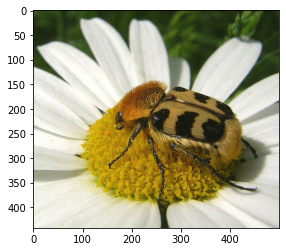

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
img,label=dataset[120] 
plt.imshow(img)

In [9]:
#normalise the image dataset as per imagenet stats

import torchvision.transforms as tt
img_size=224
imagenet_stats=([0.485,.456,.406],[0.229,.224,.225])


In [11]:
import torchvision.transforms as tt
dataset=ImageFolder(data_dir,tt.Compose([
                                         tt.Resize(img_size),
                                         tt.RandomCrop(img_size),
                                         tt.ToTensor(),
                                         tt.Normalize(*imagenet_stats)]))

data split

In [14]:
val_pct=0.1
val_size=int(val_pct *len(dataset))#we dont want decimal values
train_size=len(dataset)-val_size

train_size,val_size

(3886, 431)

In [15]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_ds,valid_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(valid_ds)

batch_size=64
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)

valid_dl=DataLoader(valid_ds,batch_size,num_workers=4,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)


model setup

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
from torchvision import models

class ResNet34(ImageClassificationBase):
  def __init__(self,num_classes,pretrained=True):#pretrained on imagenet dataset
    super().__init__()
    #use a pretrained model
    self.network=models.resnet34(pretrained=pretrained)
    #replace last layer
    self.network.fc=nn.Linear(self.network.fc.in_features,num_classes)

  def forward(self,xb):
    return self.network(xb)

In [27]:
model=to_device(ResNet34(len(dataset.classes),pretrained =True),device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [28]:
history=[evaluate(model,valid_dl)]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [29]:
history

[{'val_acc': 0.2148556262254715, 'val_loss': 1.793983817100525}]

In [30]:
model

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [31]:
import torch
from tqdm.notebook import tqdm
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
#learning rate varies , increasing by factor of 10 for 30% of iteration then increasing
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
history+=fit_one_cycle(6,0.001,model,train_dl,valid_dl,weight_decay=0.1,grad_clip=0.1,opt_func=torch.optim.SGD)

  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.3461, val_loss: 0.6646, val_acc: 0.8210


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.4928, val_loss: 0.3305, val_acc: 0.9148


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.3206, val_loss: 0.2644, val_acc: 0.9217


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.2559, val_loss: 0.2372, val_acc: 0.9245


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2147, val_loss: 0.2216, val_acc: 0.9328


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.1972, val_loss: 0.2154, val_acc: 0.9351


OUTPUT

In [33]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [34]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [35]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [36]:
import numpy as np
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

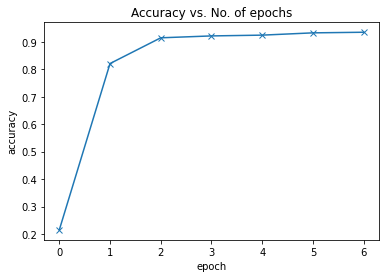

In [37]:
plot_accuracies(history)

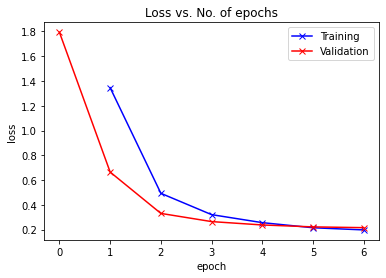

In [38]:
plot_losses(history)

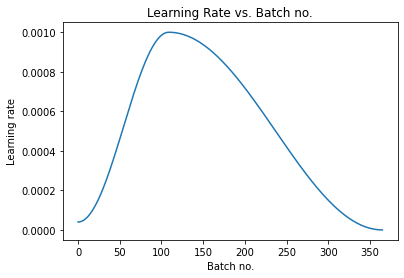

In [39]:
plot_lrs(history)

PREDICTION VS TRUE 

In [41]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

Label: sunflower (3)
predicted: sunflower


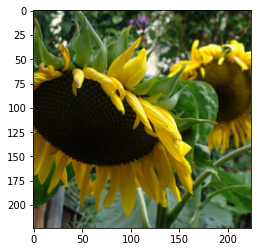

In [42]:
img,label=valid_ds[0]
show_image(img,label)
pred=predict_image(img,model,dataset.classes)
print('predicted:',pred)

Label: tulip (4)
predicted: tulip


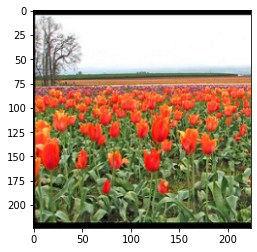

In [43]:
img,label=valid_ds[10]
show_image(img,label)
pred=predict_image(img,model,dataset.classes)
print('predicted:',pred)

Label: daisy (0)
predicted: daisy


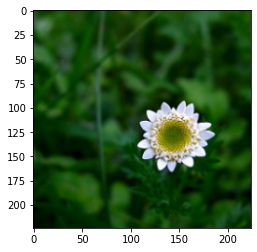

In [44]:
img,label=valid_ds[100]
show_image(img,label)
pred=predict_image(img,model,dataset.classes)
print('predicted:',pred)